<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Pipeline de Dados do Telegram II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Storytelling.</li>
</ol>

---

# **Exercícios**

## 1\. Ingestão

Replique as atividades da aula 1.

1.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados crus, não se esqueça de adicionar o sufixo `-raw`.

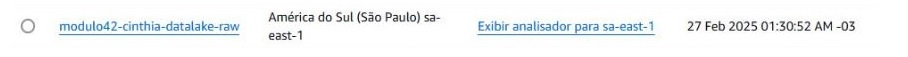

1.2. Crie uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. Não se esqueça de configurar as variáveis de ambiente e de adicionar as permissão de interação com `AWS S3` no `AWS IAM`.

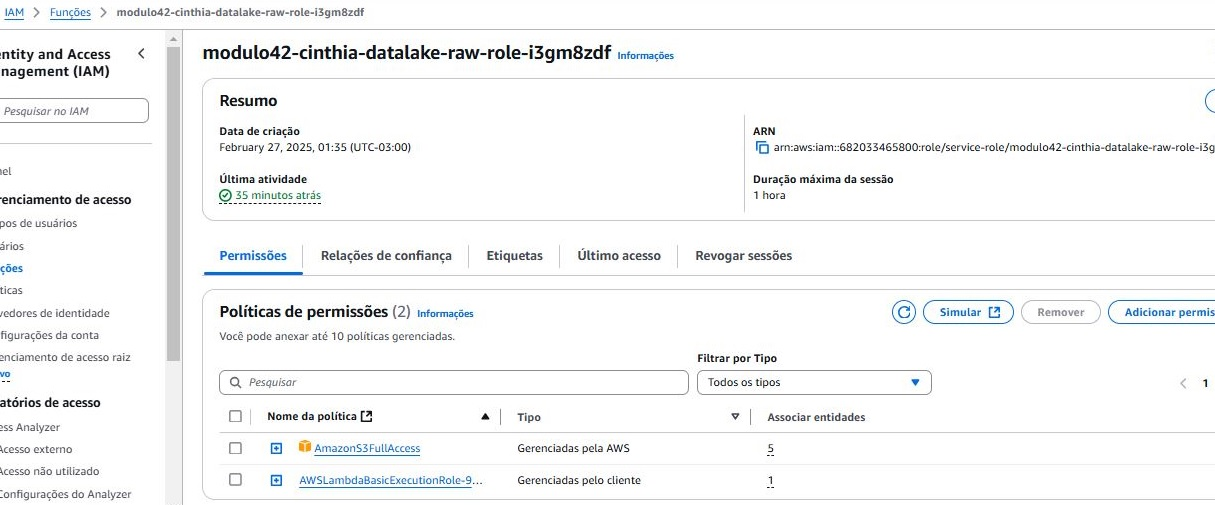

> **Nota**: Para testar a função com evento do próprio `AWS Lambda`, substitua o código `message = json.loads(event["body"])` por `message = event`. Lembre-se que o primeiro só faz sentido na integração com o `AWS API Gateway`.

1.3. Crie uma API no `AWS API Gateway` a conecte a função do `AWS Lambda`, conforme apresentado na aula.

> **Nota**: não disponibilize o endereço da API gerada.

1.4. Configura o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. utilize o endereço da API criada no `AWS API Gateway`. Utilize o método `getWebhookInfo` para consultar a integração.

> **Nota**: não disponibilize o *token* de acesso ao seu *bot* da API de *bots* do **Telegram**.

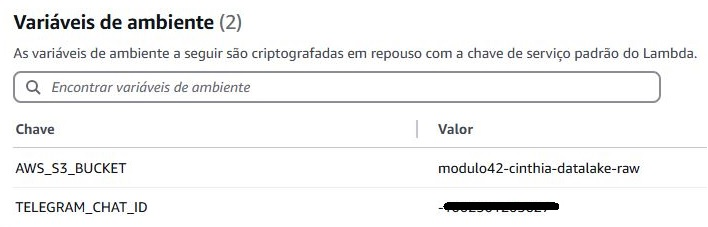

In [ ]:
# Função Lambda

import os
import json
import logging
import traceback
from datetime import datetime, timedelta, timezone
import boto3

def lambda_handler(event, context):
    '''
    Recebe mensagens do Telegram via AWS API Gateway, verifica se foram enviadas
    em um determinado grupo e armazena no S3.
    '''
    # Configuração do logger
    logging.basicConfig(level=logging.INFO)

    # Variáveis de ambiente
    BUCKET = os.environ['AWS_S3_BUCKET']
    TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

    # Configuração de fuso horário
    tzinfo = timezone(offset=timedelta(hours=-3))
    date = datetime.now(tzinfo).strftime('%Y-%m-%d')
    client = boto3.client('s3')

    try:
        # Verifica se `event` já é uma lista ou um JSON serializado
        if isinstance(event, list):
            messages = event  # O evento já é uma lista, não precisa de json.loads()
        elif "body" in event:
            body = json.loads(event["body"])  # Converte JSON string para dicionário/lista
            messages = body if isinstance(body, list) else [body]
        else:
            raise ValueError("Formato inesperado de evento")

        for message in messages:
            if "message" in message:
                chat_id = message["message"]["chat"]["id"]

                if chat_id == TELEGRAM_CHAT_ID:
                    timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')
                    filename = f"{timestamp}.json"
                    file_path = f"/tmp/{filename}"

                    # Salva o JSON temporariamente
                    with open(file_path, mode='w', encoding='utf8') as fp:
                        json.dump(message, fp)

                    # Faz o upload para o S3
                    s3_key = f'telegram/context_date={date}/{filename}'
                    client.upload_file(file_path, BUCKET, s3_key)
                    logging.info(f"Arquivo {filename} enviado para {s3_key}")

        return {"statusCode": "200"}

    except Exception as exc:
        logging.error(f"Erro: {exc}\n{traceback.format_exc()}")
        return {"statusCode": "500"}

In [ ]:
# Função de teste - telegram-mensagem2

[
  {
    "update_id": 891223712,
    "my_chat_member": {
      "chat": {
        "id": -1002301203627,
        "title": "Cinthiaemodulo42ebac",
        "type": "supergroup"
      },
      "from": {
        "id": 7835041698,
        "is_bot": false,
        "first_name": "Cinthia",
        "last_name": "MS"
      },
      "date": 1740630485,
      "old_chat_member": {
        "user": {
          "id": 7973422808,
          "is_bot": true,
          "first_name": "modulo42ebac",
          "username": "modulo42ebacbot"
        },
        "status": "member"
      },
      "new_chat_member": {
        "user": {
          "id": 7973422808,
          "is_bot": true,
          "first_name": "modulo42ebac",
          "username": "modulo42ebacbot"
        },
        "status": "administrator",
        "can_be_edited": false,
        "can_manage_chat": true,
        "can_change_info": false,
        "can_delete_messages": false,
        "can_invite_users": false,
        "can_restrict_members": false,
        "can_pin_messages": false,
        "can_manage_topics": true,
        "can_promote_members": false,
        "can_manage_video_chats": false,
        "can_post_stories": false,
        "can_edit_stories": false,
        "can_delete_stories": false,
        "is_anonymous": false,
        "can_manage_voice_chats": false,
        "custom_title": "Admin"
      }
    }
  },
  {
    "update_id": 891223713,
    "message": {
      "message_id": 5,
      "from": {
        "id": 7835041698,
        "is_bot": false,
        "first_name": "Cinthia",
        "last_name": "MS"
      },
      "chat": {
        "id": -1002301203627,
        "title": "Cinthiaemodulo42ebac",
        "type": "supergroup"
      },
      "date": 1740630513,
      "text": "teste"
    }
  },
  {
    "update_id": 891223714,
    "message": {
      "message_id": 6,
      "from": {
        "id": 7835041698,
        "is_bot": false,
        "first_name": "Cinthia",
        "last_name": "MS"
      },
      "chat": {
        "id": -1002301203627,
        "title": "Cinthiaemodulo42ebac",
        "type": "supergroup"
      },
      "date": 1740630553,
      "text": "teste mudando algumas configurações"
    }
  }
]

In [ ]:
# Mensagem de sucesso

Status: Succeeded
Test Event Name: telegram-messagem2

Response:
{
  "statusCode": "200"
}

Function Logs:
START RequestId: 88c89394-bbe3-4922-9933-d7f30dd595ec Version: $LATEST
END RequestId: 88c89394-bbe3-4922-9933-d7f30dd595ec
REPORT RequestId: 88c89394-bbe3-4922-9933-d7f30dd595ec	Duration: 2890.41 ms	Billed Duration: 2891 ms	Memory Size: 128 MB	Max Memory Used: 82 MB	Init Duration: 275.95 ms

Request ID: 88c89394-bbe3-4922-9933-d7f30dd595ec

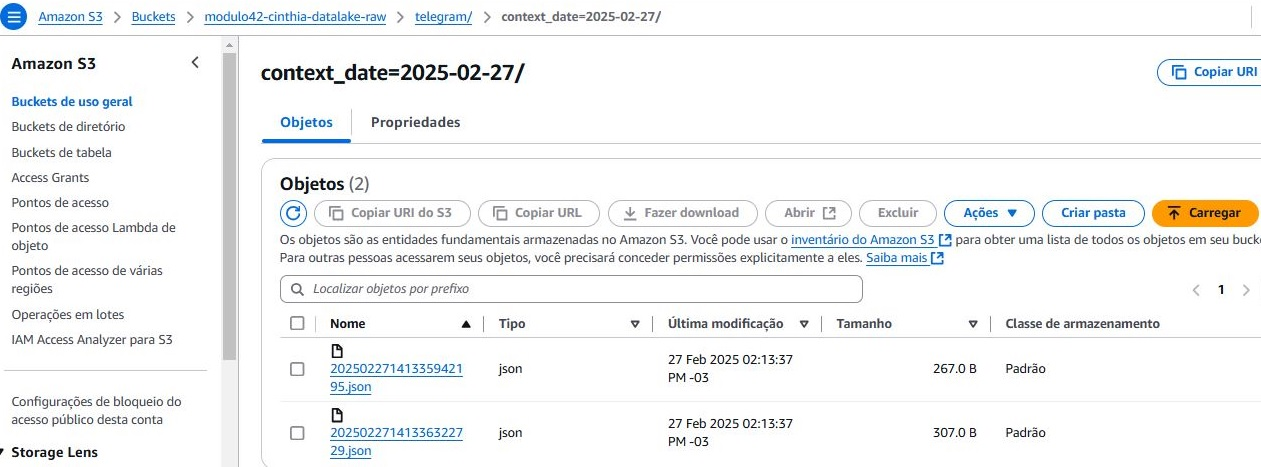

## 2\. ETL

Replique as atividades da aula 2.

2.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos, não se esqueça de adicionar o sufixo `-enriched`.

2.2. Cria uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. Salve o resultado em um único arquivo PARQUET, também particionado por dia. Não se esqueça de configurar as variáveis de ambiente, de adicionar as permissão de interação com `AWS S3` no `AWS IAM`, de configurar o *timeout* e de adicionar a *layer* com o código do pacote Python PyArrow.

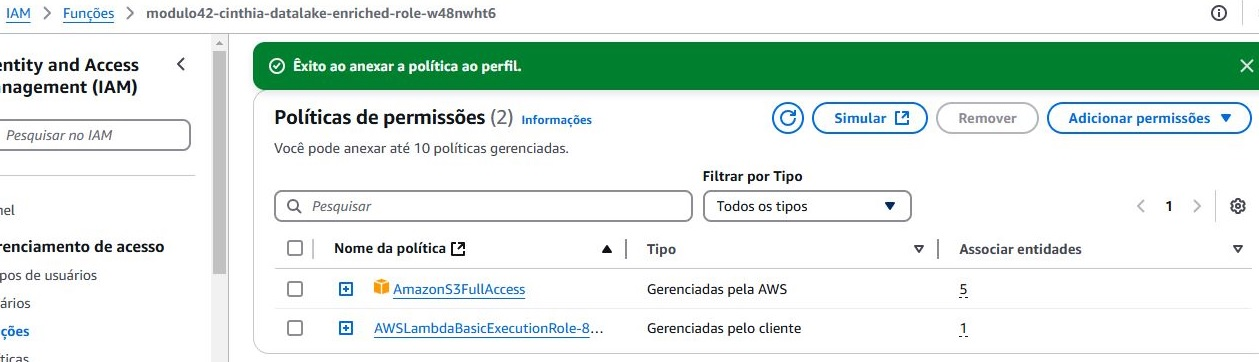

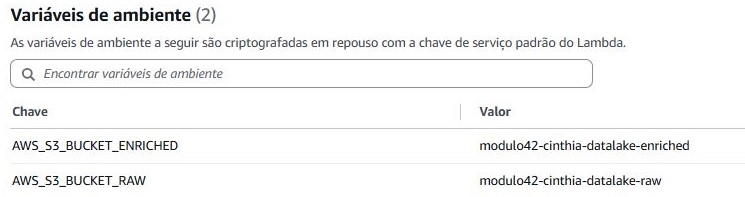

> **Nota**: Para testar a função, substitua o código `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia.

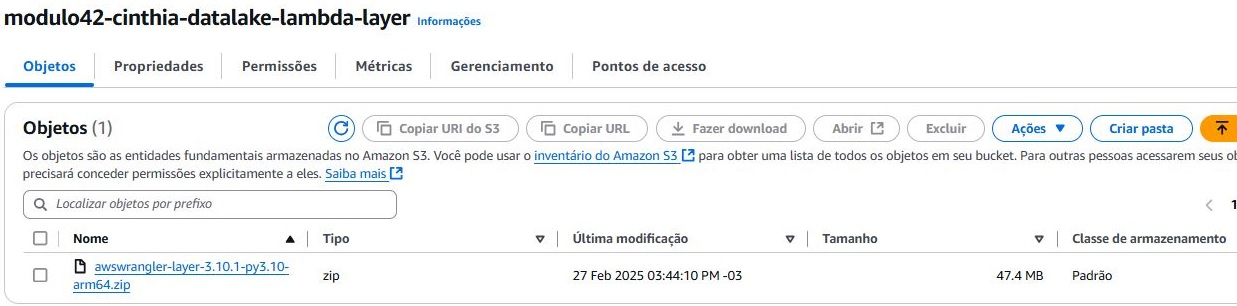

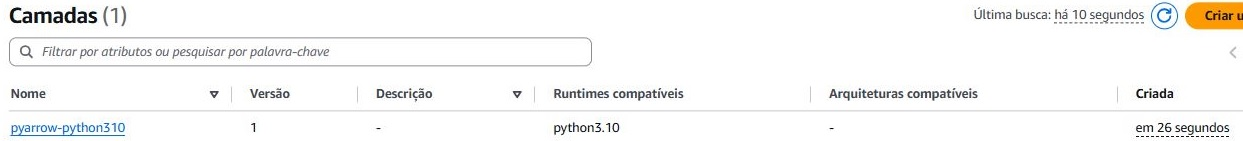

In [ ]:
# Função Lambda

import os
import json
import logging
from datetime import datetime, timedelta, timezone
import traceback
import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET_RAW']
  ENRICHED_BUCKET = os.environ['AWS_S3_BUCKET_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

In [ ]:
# Função de teste

{
  "key1": "value1",
  "key2": "value2",
  "key3": "value3"
}

2.3. Crie uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

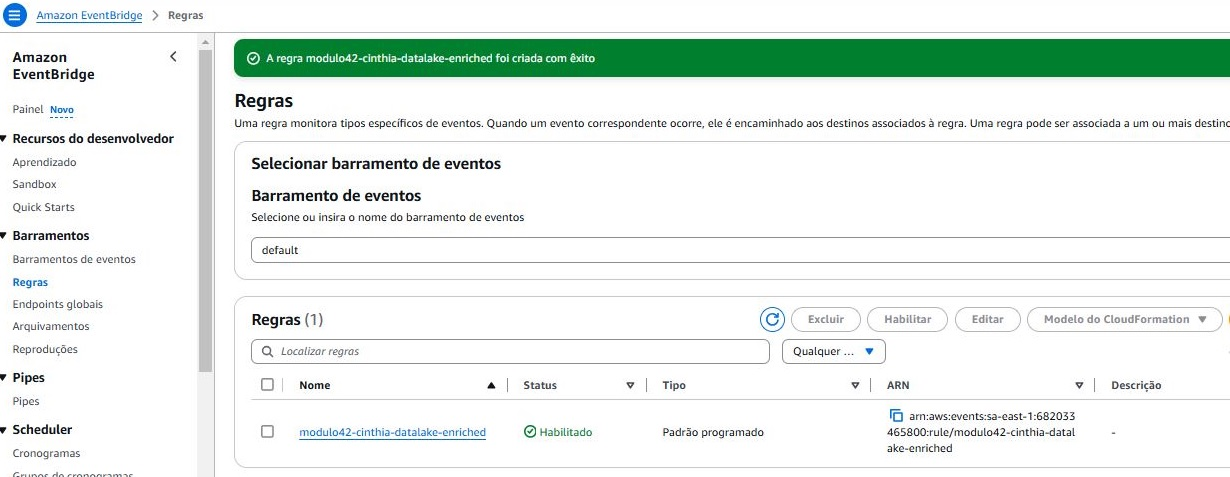

## 3\. Apresentação

Replique as atividades da aula 3.

3.1. Cria a tabela no `AWS Athena` que aponte para os dados armazenados no bucket enriquecido do `AWS S3`.

3.2. Execute o comando `MSCK REPAIR TABLE <nome-tabela>` para carregar as partições.

3.3. Execute as consultas SQL para explorar os dados.

In [ ]:
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'

    MSCK REPAIR TABLE `telegram`;

    SELECT * FROM `telegram` LIMIT 10;

    SELECT
      context_date,
      count(1) AS "message_amount"
    FROM "telegram"
    GROUP BY context_date
    ORDER BY context_date DESC

    SELECT
      user_id,
      user_first_name,
      context_date,
      count(1) AS "message_amount"
    FROM "telegram"
    GROUP BY
      user_id,
      user_first_name,
      context_date
    ORDER BY context_date DESC

    SELECT
      user_id,
      user_first_name,
      context_date,
      CAST(AVG(length(text)) AS INT) AS "average_message_length"
    FROM "telegram"
    GROUP BY
      user_id,
      user_first_name,
      context_date
    ORDER BY context_date DESC

    WITH
    parsed_date_cte AS (
        SELECT
            *,
            CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
        FROM "telegram"
    ),
    hour_week_cte AS (
        SELECT
            *,
            EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
            EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
            EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
        FROM parsed_date_cte
    )

    SELECT
        parsed_date_hour,
        parsed_date_weekday,
        parsed_date_weeknum,
        count(1) AS "message_amount"
    FROM hour_week_cte
    GROUP BY
        parsed_date_hour,
        parsed_date_weekday,
        parsed_date_weeknum
    ORDER BY
        parsed_date_weeknum,
        parsed_date_weekday



## 4\. Storytelling

Siga as dicas da aula 4 para expor o seu projeto.

- Qualidade dos dados: ajuda a identificar e corrigir problemas nos dados, como valores ausentes ou inconsistentes, garantindo que os modelos e análises não sejam baseados em informações erradas.

- Escolha das ferramentas: ajuda a compreender os dados permite selecionar as ferramentas e técnicas certas para tratá-los de maneira eficaz, como a aplicação de métodos de redução de dimensionalidade para dados complexos.

- Desenvolvimento de modelos: AED oferece uma visão das relações entre as variáveis, o que é crucial para criar modelos preditivos ou de classificação precisos.

- Tomada de decisões: auxilia na compreensão dos dados para responder perguntas de negócios, como identificar os principais fatores que afetam o engajamento dos usuários ou as áreas de maior interesse dos clientes.